# Plot data windows with labels

- Load data tile
- Load labels 
- Create cutout windows including labels
- Plot


In [207]:
import os
# workdir = '/gpfs/home3/mizeboud/'
# os.chdir(os.path.join(workdir,'preprocessing/scripts/train-vae/'))
homedir = '/Users/tud500158/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - TUD500158/'
os.chdir(os.path.join(homedir,'github/AutomatedDamageDetection/scripts/train-vae/'))
import numpy as np
import tensorflow as tf
import glob
import os
import matplotlib.pyplot as plt

# own modules
import dataset
import tiles as ts

# from shapely import geometry
from rasterio.features import shapes, geometry_mask
import pathlib
import pandas as pd
import rioxarray as rioxr
import geopandas as gpd
import xarray as xr
print('---- modules imported')
# os.chdir(workdir)


---- modules imported


### Define data tile

In [208]:

# # Training tile
# tileNum = 'tile_140'
# tile_file = '/projects/0/einf512/S2_composite_2019-11-1_2020-3-1/S2_composite_2019-11-1_2020-3-1_tile_140.tif'
# dmg_file = '/projects/0/einf512/NERD/damage_detection/S2_composite_2019-11-1_2020-3-1_tile_140_300m_damageContin.tif'

# Validation tile:
# tileNum = 'tile_50'
# tile_file = "/projects/0/einf512/S2_composite_2019-11-1_2020-3-1/S2_composite_2019-11-1_2020-3-1_tile_50.tif"
# dmg_file = '/projects/0/einf512/NERD/damage_detection/S2_composite_2019-11-1_2020-3-1_tile_50_300m_damageContin.tif'

## local machien: training tiles
tile_folder = os.path.join(homedir,'Data/tiles/training_tiles/')
tile_list = [file for file in os.listdir(tile_folder) if file.endswith('.tif')]
print(tile_list)
tile_file = os.path.join(tile_folder,'S2_composite_2019-11-1_2020-3-1_tile_140.tif')

tileName = tile_file.split("/")[-1][:-4] 
tileName
    

['S2_composite_2019-11-1_2020-3-1_tile_140.tif']


'S2_composite_2019-11-1_2020-3-1_tile_140'

### Functions

In [209]:
def create_cutouts2(da,cutout_size, normThreshold=None, equalise=False):

    # generate windows
    da = da.rolling(x=cutout_size, y=cutout_size)
    da = da.construct({'x': 'x_win', 'y': 'y_win'}, stride=cutout_size)

    # drop NaN-containing windows
    da = da.stack(sample=('x', 'y'))
    da = da.dropna(dim='sample', how='any')

    tile_cutouts = da.data.transpose(3, 1, 2, 0) # samples, x_win, y_win, bands: (250000, 20, 20, 3)
    tile_cutouts_da = da.transpose('sample','x_win','y_win','band')

    return tile_cutouts, tile_cutouts_da



def load_nerd_dmg_tile_labels(dmg_file,tile_da, cutout_size):
    ''' ----------
    Load Labels: processed dmg
    ------------'''
    
    tile_dmg = rioxr.open_rasterio(dmg_file).astype("float32")

    # interpolate dmg to same resolution as tile (to link as labels)
    tile_dmg_int = tile_dmg.isel(band=0).interp_like(tile_da.isel(band=0))
    tile_dmg_int= tile_dmg_int.fillna(0).expand_dims(dim='band') # fill nan with zeros and add band-dim
            
    label_cutouts, label_cutouts_da = create_cutouts2(tile_dmg_int, cutout_size)  
    labels_ldim = label_cutouts.sum(axis=1).sum(axis=1) # (Nsamples, x_win, y_win, 1) to (Nsamples,1)  
    labels_ldim_da = label_cutouts_da.sum(axis=1).sum(axis=1) # (Nsamples, x_win, y_win, 1) to (Nsamples,1)      
    return labels_ldim, labels_ldim_da


def normalise_and_equalise(da,normThreshold=None,equalise=False):
    
    # normalize
    if normThreshold is not None:
        da = (da + 0.1) / (normThreshold + 1)
        da = da.clip(max=1)
    
    if equalise:
        # hist equalist
        n_bands = da['band'].shape[0]
        all_band_eq=np.empty(da.shape)

        for band_i in range(n_bands): # perform adaptive normalisation per band
            band_data = da.isel(band=band_i)
            band_data_eq = skimage_exposure.equalize_adapthist(band_data, clip_limit=0.03)
            all_band_eq[band_i] = np.expand_dims(band_data_eq,axis=0)

        da = da.copy(data=all_band_eq) # overwrite data in dataArray
    
    return da

    

### Load tile ,create cut outs

In [210]:
import geopandas as gpd

In [211]:
cutout_size = 20
catalog_path = os.path.join(homedir,'Data/tiles/')
labels_path = os.path.join(homedir,'Data/tiles/manual_labels_S2-DJF-2019/EPSG4326/')
normThreshold = [10000]

''' ----------
Load tile
------------'''

# for tile in tile_list: # from dataset.py _generate_cutouts


tileName = tile_file.split("/")[-1][:-4] # vb: 'S2_composite_2019-11-1_2020-3-1_tile_124'
tileNum='tile_'+tileName.split('tile_')[-1]

print('----\n Processing ' + tileName +'\n')

# read tile - floats are required to mask with NaN's
da = rioxr.open_rasterio(tile_file).astype("float32")

da = da.assign_attrs({'long_name':'Red-band'})

# imres = da.rio.resolution()
# if int(imres[0]) == 10:
#     da = da.coarsen(x=3,y=3,boundary='pad').mean() # mean downsampling 

# # select bands
# if bands is not None:
#     if type(bands) is not list:
#         da = da.sel(band=[bands])
#     else:
#         da = da.sel(band=bands)

''' ----------
Mask ocean
------------'''

# mask/clip: if self.mask is not None: [removed; see _generate_cutouts]
# da = mask_data(da,mask_file)


''' ----------
Normalise and Equalise
------------'''

# da = normalise_and_equalise(da,normThreshold=normThreshold[0],equalise=True)
# da = normalise_and_equalise(da,normThreshold=normThreshold[0],equalise=False)


''' ----------
Plot tile (for test phase)
------------'''
# try: 
#     fig,ax= plt.subplots(1,figsize=(7,8))
#     da.attrs['long_name']='imgbands';
#     da.plot.imshow(ax=ax,rgb='band', vmin=0,vmax=1)
#     ax.set_title(tileNum + ' normalised')
#     ax.set_aspect('equal')
#     # fig.savefig(os.path.join(path_to_traindir , model_dir, tileNum + '_normalised_histEq'))
#     fig.savefig(os.path.join(path_to_model, tileNum + '_normalised' ))
# except Exception:
#     print('Error for plotting image -- skipped')
#     pass

''' ----------
Create cut-outs
------------'''

# generate windows -- cut 

tile_cutouts, tile_cutouts_da = create_cutouts2(da,cutout_size) # samples, x_win, y_win, bands: (250000, 20, 20, 1)
# label_cutouts, __ = create_cutouts(tile_dmg_int, cutout_size)
print('cutouts {} // {}'.format(tile_cutouts.shape,tile_cutouts_da.shape))

    

----
 Processing S2_composite_2019-11-1_2020-3-1_tile_140

cutouts (390625, 20, 20, 4) // (390625, 20, 20, 4)


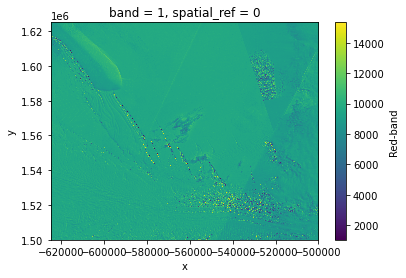

In [212]:

da.isel(band=0).plot.imshow()


In [213]:

# # read tile - floats are required to mask with NaN's
# da_raw = rioxr.open_rasterio(tile_file).astype("float32")
# da_raw.attrs['long_name'] = 'bands'

In [214]:

# fig,axs=plt.subplots(1,2)
# ax=axs[0]
# da_raw.isel(band=0).plot.imshow(ax=ax,cmap='gray')
# ax.set_aspect('equal')
# ax.set_title('original img')
# ax=axs[1]
# da.isel(band=0).plot.imshow(ax=ax,cmap='gray')
# ax.set_aspect('equal')
# ax.set_title('HistEq.Normalised')

Labels successfully read from 2 files


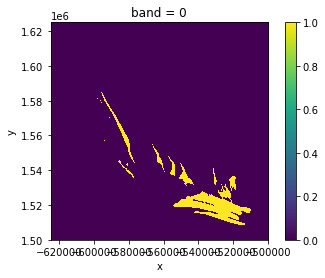

In [215]:

''' ----------
Get Labels
------------'''

# # read tile catalog to be able to get CRS and filter labels to same date
catalog = ts._read_tile_catalog(catalog_path)
tiles = ts._catalog_to_geodataframe(catalog)

labels = ts._read_labels(labels_path, verbose=True)
labels = labels.to_crs(da.rio.crs)  # make sure same CRS is used
# select the only labels matching the tiles timespan
# labels = ts._filter_labels(labels,
#                         tiles.start_datetime.min(),
#                         tiles.end_datetime.max())


## Create GeoSeries from labels.geometry
label_polys = gpd.GeoSeries(labels.geometry,crs=labels.crs) # Combine all geometries to one GeoSeries, with the 

## Remove empty shapes
label_polys = label_polys.loc[~label_polys.is_empty]




## Burn labels into tile raster

mmask = geometry_mask(label_polys,out_shape=(len(da.y),len(da.x)),transform=da.rio.transform(),invert=True)
mmask = np.expand_dims(mmask,axis=0)
m2mask = mmask.astype(np.dtype('uint16'))

## make dataArray
label_tile = xr.DataArray(data=m2mask,dims=['band','y','x'],coords={'band':[0],'y':da[0].coords['y'],'x':da[0].coords['x']})

## label cutouts:
_, label_cutouts_da = create_cutouts2(label_tile,cutout_size) # samples, x_win, y_win, bands: (250000, 20, 20, 1)

## plot
fig,ax=plt.subplots()
label_tile.isel(band=0).plot.imshow(ax=ax); ax.set_aspect('equal')

<AxesSubplot:>

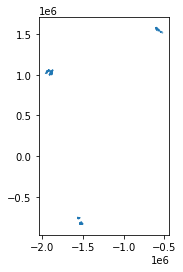

In [216]:
label_polys.plot()

In [217]:
# tile_labels = xr.concat([tile_cutouts_da,label_cutouts_da],dim='band').sel(band=[0,1])
# tile_labels


In [218]:
# sample a few pixels
# tile_labels.to_dataframe(name='tile_labels')#.sample(50)

# windows_label1= tile_labels.sel(band=[0,1]).where(label_cutouts_da.isel(band=0)>0,drop=True)
# windows_label1 # band=0: labels. Band=1 Red-band

label_sample_idx = label_cutouts_da.isel(band=0).sum(dim=['x_win','y_win']) >0
label_sample_idx

tile_windows = tile_cutouts_da.sel(band=1).isel(sample=label_sample_idx).assign_attrs({'long_name':'Red-band'})
tile_labels  = label_cutouts_da.sel(band=0).isel(sample=label_sample_idx).assign_attrs({'long_name':'label'})
# windows_label1 = tile_labels.sel(band=[0,1]).isel(sample=label_sample_idx)
tile_windows # sample, x_win,y_win

<xarray.DataArray (sample: 17419, x_win: 20, y_win: 20)>
array([[[ 9416.,  8472.,  8100., ..., 10720.,  9976.,  9904.],
        [ 9360.,  9680.,  8004., ..., 10304., 10304.,  9920.],
        [ 9608.,  9152.,  7508., ..., 10368., 10400., 10096.],
        ...,
        [ 8616.,  8856.,  9000., ...,  6504.,  9784.,  9640.],
        [ 8472.,  8744.,  8848., ...,  7872.,  8680.,  9208.],
        [ 8328.,  8584.,  8656., ...,  3394.,  4050.,  5560.]],

       [[ 9920.,  9840.,  9816., ..., 10072., 10144., 10096.],
        [ 9920.,  9872.,  9904., ..., 10040., 10048., 10096.],
        [ 9960.,  9944.,  9960., ..., 10008., 10048., 10048.],
        ...,
        [10216., 10104., 10016., ...,  9784.,  9792.,  9784.],
        [10216., 10192.,  9992., ...,  9816.,  9872.,  9904.],
        [10256., 10256., 10144., ...,  9800.,  9840.,  9840.]],

       [[ 9640.,  9656.,  9536., ...,  9608.,  9512.,  9568.],
        [ 9496.,  9600.,  9592., ...,  9496.,  9560.,  9512.],
        [ 9296.,  9536.,  9464., ...,  9536.,  9520.,  9488.],
        ...,
...
        [ 8816.,  9008.,  9280., ...,  9464.,  9512.,  9496.],
        [ 9336.,  9744.,  9440., ...,  9000.,  9080.,  9256.],
        [ 9440.,  9368.,  9680., ...,  9304.,  9224.,  9368.]],

       [[10520., 10360.,  8060., ..., 11512., 11272., 10008.],
        [ 9776.,  9808.,  9944., ...,  9600., 10280., 10792.],
        [ 8488.,  8156.,  8768., ...,  9232.,  9512., 11008.],
        ...,
        [ 8856.,  9008.,  8840., ...,  8976.,  8760.,  9520.],
        [ 7792.,  7792.,  9216., ...,  8976.,  8880.,  9016.],
        [ 9768., 10544.,  8936., ...,  9152.,  9088.,  9336.]],

       [[ 9048.,  8592.,  9728., ...,  9432.,  9448.,  9456.],
        [10536.,  8592.,  8648., ...,  9744.,  9696.,  9504.],
        [11776.,  9752.,  9120., ..., 10232.,  9728.,  9416.],
        ...,
        [ 9368.,  9544.,  8968., ...,  8464.,  9080.,  8856.],
        [ 8976.,  8968.,  9456., ...,  7588.,  8232.,  8092.],
        [ 9128.,  9280.,  9096., ...,  7924.,  7736.,  7992.]]],
      dtype=float32)
Coordinates:
    band         int64 1
    spatial_ref  int64 0
  * sample       (sample) MultiIndex
  - x            (sample) float64 -6.068e+05 -6.066e+05 ... -5.1e+05 -5.1e+05
  - y            (sample) float64 1.577e+06 1.585e+06 ... 1.517e+06 1.517e+06
Dimensions without coordinates: x_win, y_win
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     Red-band

In [219]:
tile_windows
tile_windows.isel(sample=slice(0,10))

<xarray.DataArray (sample: 10, x_win: 20, y_win: 20)>
array([[[ 9416.,  8472.,  8100., ..., 10720.,  9976.,  9904.],
        [ 9360.,  9680.,  8004., ..., 10304., 10304.,  9920.],
        [ 9608.,  9152.,  7508., ..., 10368., 10400., 10096.],
        ...,
        [ 8616.,  8856.,  9000., ...,  6504.,  9784.,  9640.],
        [ 8472.,  8744.,  8848., ...,  7872.,  8680.,  9208.],
        [ 8328.,  8584.,  8656., ...,  3394.,  4050.,  5560.]],

       [[ 9920.,  9840.,  9816., ..., 10072., 10144., 10096.],
        [ 9920.,  9872.,  9904., ..., 10040., 10048., 10096.],
        [ 9960.,  9944.,  9960., ..., 10008., 10048., 10048.],
        ...,
        [10216., 10104., 10016., ...,  9784.,  9792.,  9784.],
        [10216., 10192.,  9992., ...,  9816.,  9872.,  9904.],
        [10256., 10256., 10144., ...,  9800.,  9840.,  9840.]],

       [[ 9640.,  9656.,  9536., ...,  9608.,  9512.,  9568.],
        [ 9496.,  9600.,  9592., ...,  9496.,  9560.,  9512.],
        [ 9296.,  9536.,  9464., ...,  9536.,  9520.,  9488.],
        ...,
...
        [ 8720.,  8656.,  8640., ...,  8536.,  8472.,  8440.],
        [ 8744.,  8768.,  8744., ...,  8512.,  8552.,  8496.],
        [ 8672.,  8704.,  8688., ...,  8512.,  8440.,  8536.]],

       [[ 8352.,  8360.,  8416., ...,  4220.,  3626.,  2988.],
        [ 8264.,  8264.,  8240., ...,  6636.,  4192.,  4272.],
        [ 8264.,  8216.,  8124., ...,  9592.,  7240.,  4700.],
        ...,
        [ 8368.,  8408.,  8480., ...,  7928.,  7928.,  7944.],
        [ 8368.,  8384.,  8384., ...,  8004.,  7960.,  8008.],
        [ 8448.,  8504.,  8464., ...,  8116.,  8124.,  8208.]],

       [[10160., 10176., 10224., ...,  9664.,  9744.,  9840.],
        [10128., 10160., 10176., ...,  9792.,  9832.,  9768.],
        [ 9992.,  9984.,  9992., ...,  9816.,  9816.,  9832.],
        ...,
        [ 9768.,  9768.,  9752., ...,  9504.,  9480.,  9504.],
        [ 9704.,  9704.,  9752., ...,  9544.,  9504.,  9504.],
        [ 9704.,  9744.,  9768., ...,  9552.,  9552.,  9408.]]],
      dtype=float32)
Coordinates:
    band         int64 1
    spatial_ref  int64 0
  * sample       (sample) MultiIndex
  - x            (sample) float64 -6.068e+05 -6.066e+05 ... -6.064e+05
  - y            (sample) float64 1.577e+06 1.585e+06 ... 1.577e+06 1.585e+06
Dimensions without coordinates: x_win, y_win
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     Red-band

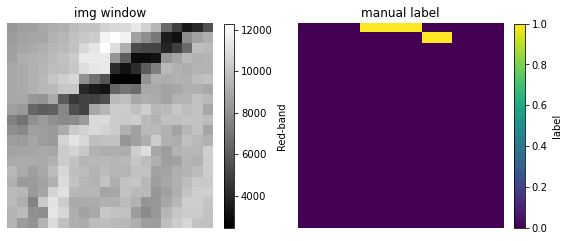

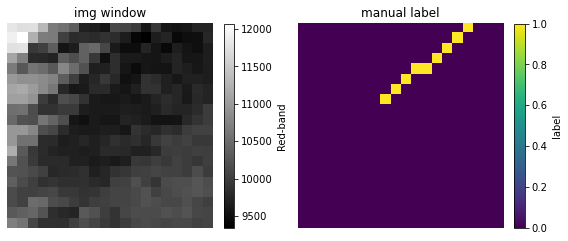

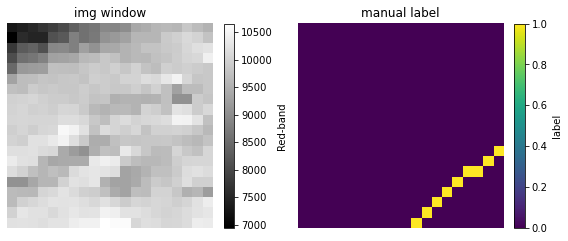

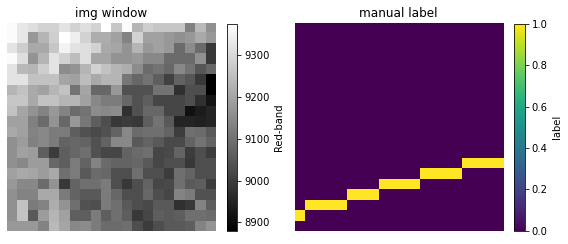

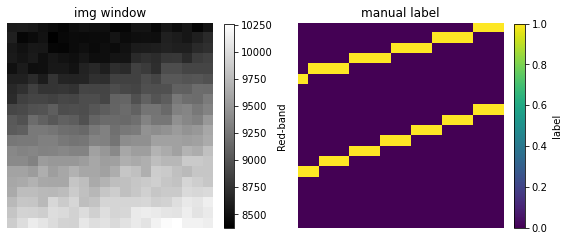

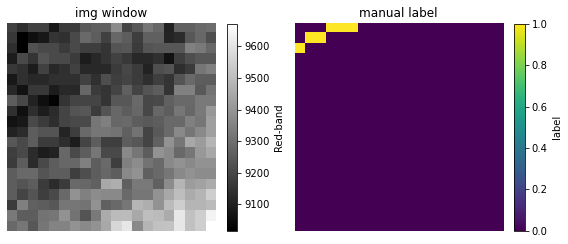

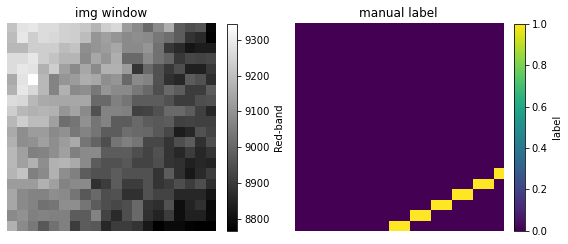

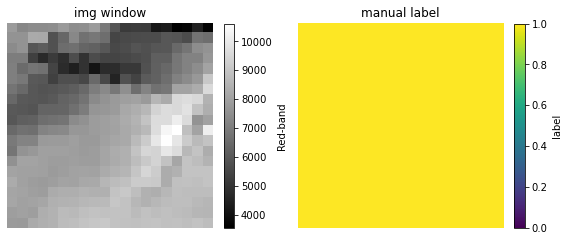

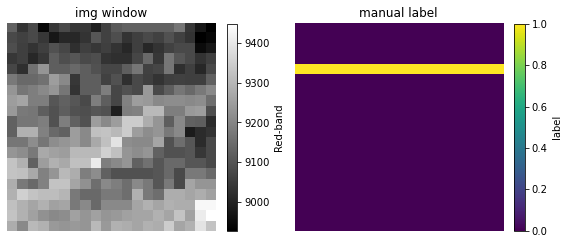

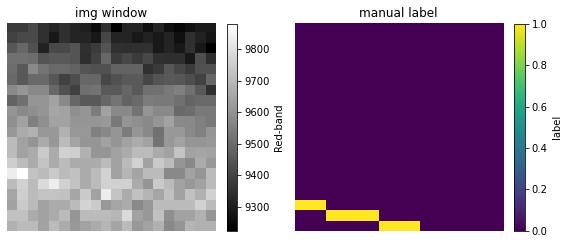

In [220]:
for s in range(0,1000,100):
    window = tile_windows.isel(sample=s)

    fig,axs=plt.subplots(1,2,figsize=(8,4))
    ax=axs[0]; tile_windows.isel(sample=s).plot.imshow(ax=ax, cmap='gray',cbar_kwargs={'fraction':0.045});
    ax.set_aspect('equal'); ax.set_title('img window'); ax.set_axis_off()
    ax=axs[1]; tile_labels.isel( sample=s).plot.imshow(ax=ax, vmin=0,vmax=1,cbar_kwargs={'fraction':0.045})
    ax.set_aspect('equal'); ax.set_title('manual label'); ax.set_axis_off()
    fig.tight_layout()



In [221]:
da = da.assign_attrs({'long_name':'hoi'}) 

In [222]:
# da2 = rioxr.open_rasterio(tile_file).astype("float32")

# # generate windows
# da2 = da2.rolling(x=cutout_size, y=cutout_size)
# da2 = da2.construct({'y': 'y_win', 'x': 'x_win'}, stride=cutout_size)

# # drop NaN-containing windows
# da2 = da2.stack(sample=('y', 'x'))
# da2 = da2.dropna(dim='sample', how='any')

# # tile_cutouts = da2.data.transpose(3, 1, 2, 0) # samples, x_win, y_win, bands: (250000, 20, 20, 3)
# # tile_cutouts_da2 = da2.transpose('sample','x_win','y_win','band')
# da2 = da2.assign_attrs({'long_name':'hoi'}) 

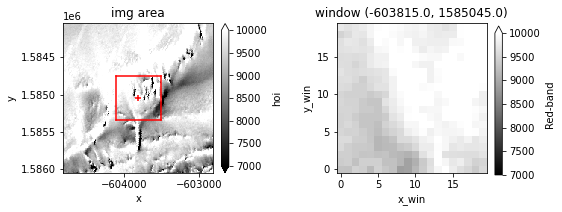

In [223]:
s = 900
# s = 10
s = 80

window_xy = tile_windows.indexes["sample"].values[s] ## all sample=(x,y) combis ; select the curren-tsample-number S
wx, wy = window_xy 

# during stacking, center=False, such that XY of window iis corner point?
# lower left cornerpoint:
window_xx = [wx, wx + cutout_size*30]
window_yy = [wy, wy + cutout_size*30]
# centerpoint:
window_xx = [wx - int(cutout_size/2)*30, wx + int(cutout_size/2)*30]
window_yy = [wy - int(cutout_size/2)*30, wy + int(cutout_size/2)*30]

dx=1e3 # in meters

window_surrounds = da.sel(band=1, 
                          x=slice(wx-dx, wx+dx) ,
                          # y=slice(1558645, 1559645), # window_xy[1],
                          y=slice(wy+dx, wy-dx) 
                          ) 
window_surrounds # (y,x)

fig,axs=plt.subplots(1,2,figsize=(8,4))
ax=axs[0]
window_surrounds.plot.imshow(ax=ax,  
                        cmap='gray',cbar_kwargs={'fraction':0.045} , 
                        vmin=7000, vmax=10000,
                        origin='lower'
                        )

ax.scatter(wx,wy,s=35,marker='+',color='red')
ax.plot(window_xx, [window_yy[0], window_yy[0]], color='red')
ax.plot(window_xx, [window_yy[1], window_yy[1]], color='red')
ax.plot([window_xx[0], window_xx[0]],  window_yy, color='red')
ax.plot([window_xx[1], window_xx[1]],  window_yy, color='red')
ax.set_aspect('equal'); ax.set_title('img area')

ax=axs[1]
tile_windows.isel(sample=s).transpose('y_win','x_win').plot.imshow(ax=ax, 
                        cmap='gray',cbar_kwargs={'fraction':0.045}, 
                        vmin=7000, vmax=10000,
                        origin='lower')
ax.set_aspect('equal'); ax.set_title('window {}'.format(window_xy));# ax.set_axis_off()
# ax=axs[1]; tile_labels.isel( sample=s).plot.imshow(ax=ax, vmin=0,vmax=1,cbar_kwargs={'fraction':0.045})
# ax.set_aspect('equal'); ax.set_title('manual label'); ax.set_axis_off()

fig.tight_layout()

## make zoom of data,then do all cutouts

In [224]:

from shapely.geometry import Polygon
import geopandas as gpd


# calculate image boundaries
def img_bound_gpd(img_da): # input: xarray dataArray

    polygon_geom = Polygon.from_bounds(*img_da.rio.bounds())
    polygon = gpd.GeoDataFrame(index=[0], crs=img_da.rio.crs, geometry=[polygon_geom])  
    
    return polygon


In [225]:
## make 1 tile iwth Red band + Label band
tile_b12_da = xr.concat([da,label_tile],dim='band').sel(band=[0,1])
tile_b12_da

<xarray.DataArray (band: 2, y: 12505, x: 12502)>
array([[[   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        ...,
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.]],

       [[9080., 9080., 9056., ..., 9504., 9456., 9432.],
        [8992., 8976., 8976., ..., 9480., 9496., 9480.],
        [9040., 8952., 9000., ..., 9480., 9536., 9480.],
        ...,
        [9016., 8968., 8944., ..., 9128., 9112., 9056.],
        [9016., 8976., 8976., ..., 9072., 9112., 9112.],
        [8968., 9056., 8896., ..., 9168., 9128., 9080.]]], dtype=float32)
Coordinates:
  * band         (band) int64 0 1
  * x            (x) float64 -6.25e+05 -6.25e+05 -6.25e+05 ... -5e+05 -5e+05
  * y            (y) float64 1.625e+06 1.625e+06 1.625e+06 ... 1.5e+06 1.5e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     hoi

In [244]:
min_x, min_y, max_x , max_y = (-21.9108, -74.8455 , -19.9011, -74.6601) # min_x, min_y, max_x , max_y
# polygon = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[ Polygon(zip(lon_point_list, lat_point_list)) ]).to_crs(3031) 


# Define extent
min_x, min_y, max_x , max_y = (-615000, 1545000 , -580000,1575000 )  # 3000 by 3500
lat_point_list = [min_y, max_y, max_y, min_y ]
lon_point_list = [min_x,  min_x,max_x, max_x]
   
polygon_large = gpd.GeoDataFrame(index=[0], crs='epsg:3031', geometry=[ Polygon(zip(lon_point_list, lat_point_list)) ])    

# Smaller extent
min_x, min_y, max_x , max_y = (-595000, 1565000 , -585000,1575000 ) # 1000 by 1000
lat_point_list = [min_y, max_y, max_y, min_y ]
lon_point_list = [min_x,  min_x,max_x, max_x] 
polygon_small = gpd.GeoDataFrame(index=[0], crs='epsg:3031', geometry=[ Polygon(zip(lon_point_list, lat_point_list)) ])    

## Select piece for window plotting
min_x, min_y, max_x , max_y = (-593000, 1570000 , -586000, 1572000 ) # 200 by 700 --> 306 window samples
min_x, min_y, max_x , max_y = (-590000, 1570000 , -588000, 1572000 ) # 200 by 700 --> 108 window samples
# min_x, min_y, max_x , max_y = (-590000, 1570000 , -589000, 1570100 ) 
lat_point_list = [min_y, max_y, max_y, min_y ]
lon_point_list = [min_x,  min_x,max_x, max_x] 
polygon_select = gpd.GeoDataFrame(index=[0], crs='epsg:3031', geometry=[ Polygon(zip(lon_point_list, lat_point_list)) ])  

## Clip the data
da_area1 = tile_b12_da.rio.clip( polygon_large.geometry, polygon_large.crs)# , drop=True, invert=False )
da_area2 = da_area1.rio.clip( polygon_small.geometry, polygon_small.crs) 


da_area_select = da_area2.rio.clip( polygon_select.geometry, polygon_select.crs) 
_, da_area_cutouts = create_cutouts2(da_area_select, cutout_size)


da_area_cutouts


<xarray.DataArray (sample: 81, x_win: 20, y_win: 20, band: 2)>
array([[[[0.0000e+00, 9.9200e+03],
         [0.0000e+00, 9.7200e+03],
         [0.0000e+00, 9.6800e+03],
         ...,
         [0.0000e+00, 9.7360e+03],
         [0.0000e+00, 9.6640e+03],
         [0.0000e+00, 9.5760e+03]],

        [[0.0000e+00, 1.0096e+04],
         [0.0000e+00, 1.0016e+04],
         [0.0000e+00, 9.6800e+03],
         ...,
         [0.0000e+00, 9.7360e+03],
         [0.0000e+00, 9.7200e+03],
         [0.0000e+00, 9.6320e+03]],

        [[0.0000e+00, 1.0008e+04],
         [0.0000e+00, 1.0008e+04],
         [0.0000e+00, 9.8960e+03],
         ...,
...
         ...,
         [1.0000e+00, 1.0344e+04],
         [1.0000e+00, 1.0136e+04],
         [1.0000e+00, 1.0344e+04]],

        [[1.0000e+00, 8.0520e+03],
         [1.0000e+00, 7.4800e+03],
         [1.0000e+00, 1.0448e+04],
         ...,
         [1.0000e+00, 9.7520e+03],
         [1.0000e+00, 9.0560e+03],
         [1.0000e+00, 9.5120e+03]],

        [[1.0000e+00, 7.4320e+03],
         [1.0000e+00, 7.6360e+03],
         [1.0000e+00, 8.6400e+03],
         ...,
         [1.0000e+00, 9.3280e+03],
         [1.0000e+00, 9.0560e+03],
         [1.0000e+00, 9.0720e+03]]]], dtype=float32)
Coordinates:
  * band         (band) int64 0 1
    spatial_ref  int64 0
  * sample       (sample) MultiIndex
  - x            (sample) float64 -5.898e+05 -5.898e+05 ... -5.882e+05
  - y            (sample) float64 1.572e+06 1.572e+06 ... 1.57e+06 1.57e+06
Dimensions without coordinates: x_win, y_win
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     hoi

/Users/tud500158/opt/anaconda3/envs/VAEenv/lib/python3.10/site-packages/geopandas/tools/clip.py:179: UserWarning: keep_geom_type can not be called on a mixed type GeoDataFrame.
  warnings.warn(
/Users/tud500158/opt/anaconda3/envs/VAEenv/lib/python3.10/site-packages/geopandas/tools/clip.py:179: UserWarning: keep_geom_type can not be called on a mixed type GeoDataFrame.
  warnings.warn(
/Users/tud500158/opt/anaconda3/envs/VAEenv/lib/python3.10/site-packages/geopandas/tools/clip.py:179: UserWarning: keep_geom_type can not be called on a mixed type GeoDataFrame.
  warnings.warn(


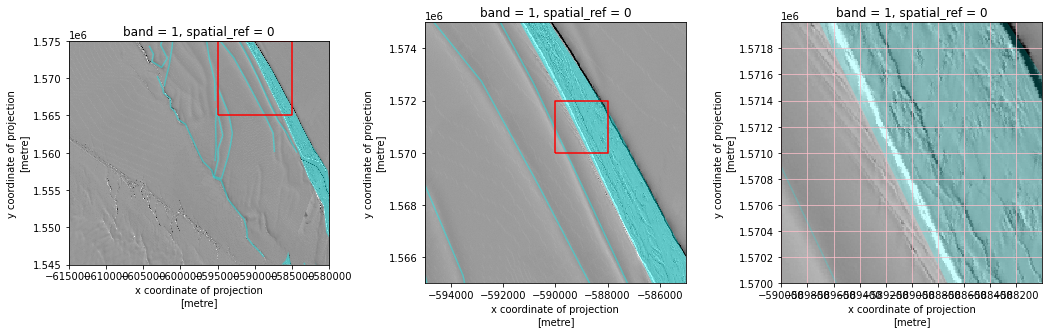

In [247]:

fig,axs=plt.subplots(1,3,figsize=(15,10))
ax=axs[0]
da_area1.sel(band=1).plot.imshow(ax=ax, add_colorbar=False,cmap='gray')
poly_img_bound = img_bound_gpd(da_area1) # shapely Polygon
label_polys.clip(poly_img_bound.geometry, poly_img_bound.crs).plot(ax=ax,color='cyan',alpha=0.4)
polygon_small.boundary.plot(ax=ax,color='red')
ax=axs[1]
da_area2.sel(band=1).plot.imshow(ax=ax, add_colorbar=False,cmap='gray')
poly_img_bound = img_bound_gpd(da_area2) # shapely Polygon
label_polys.clip(poly_img_bound.geometry, poly_img_bound.crs).plot(ax=ax,color='cyan',alpha=0.4)
polygon_select.boundary.plot(ax=ax,color='red')
# da_area_select.plot.imshow()
ax=axs[2]
da_area_select.sel(band=1).plot.imshow(ax=ax, add_colorbar=False,cmap='gray')
poly_img_bound = img_bound_gpd(da_area_select) # shapely Polygon
label_clip = label_polys.clip(poly_img_bound.geometry, poly_img_bound.crs)
label_clip.plot(ax=ax,color='cyan',alpha=0.2)

fig.tight_layout()
# plt.setp(axs,set_visible=False)

# min_x, min_y, max_x , max_y = (-590000, 1570000 , -588000, 1572000 ) # 200 by 700 --> 108 window samples
windows_x = np.arange(min_x,max_x,cutout_size*10)
windows_y = np.arange(min_y,max_y,cutout_size*10)
windows_x
ax.set_xticks(windows_x)
ax.set_yticks(windows_y)
ax.grid(which='major', alpha=0.9,color='pink')
# ax.set_xticklabels([])
# ax.set_yticklabels([])

In [239]:
# min_x, min_y, max_x , max_y = (-590000, 1570000 , -589000, 1570100 ) 

In [240]:
## Select labelled windows

# label_sample_idx = da_area_cutouts.sel(band=0).sum(dim=['x_win','y_win']) >0
# label_sample_idx

# tile_windows = da_area_cutouts.sel(band=1).isel(sample=label_sample_idx).assign_attrs({'long_name':'Red-band'})
# tile_labels  = da_area_cutouts.sel(band=0).isel(sample=label_sample_idx).assign_attrs({'long_name':'label'})
# # windows_label1 = tile_labels.sel(band=[0,1]).isel(sample=label_sample_idx)
# tile_windows # sample, x_win,y_win

In [249]:
os.getcwd()

'/Users/tud500158/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - TUD500158/github/AutomatedDamageDetection/scripts/train-vae'

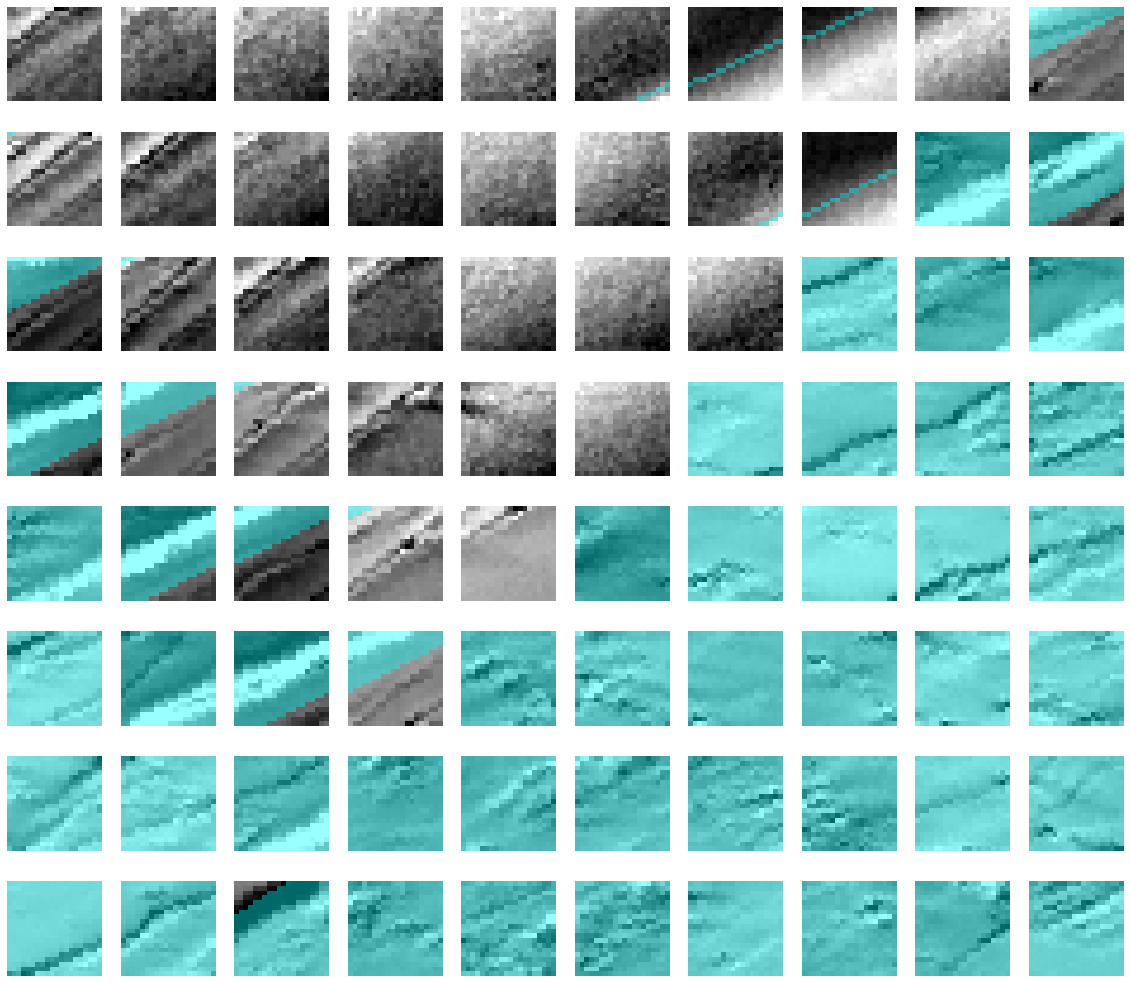

In [250]:
da_area_cutouts # 81 samples

fig,axs =plt.subplots(8,10,figsize=(20,18))
w=0
for row in range(0,8):
    for col in range(0,10): # len(da_area_cutouts)):
        ax = axs[row,col]
        # plot window
        da_area_cutouts.sel(band=1).isel(sample=w).plot.imshow( cmap='gray' ,ax=ax, add_colorbar=False )
        # plot labels
        da_area_cutouts.sel(band=0).where(
                        da_area_cutouts.sel(band=0)==1).isel(sample=w).plot.imshow( ax=ax, add_colorbar=False,
                                                                   cmap='cool_r', vmin=0,vmax=1 , alpha=0.4)
        ax.set_axis_off()
        ax.set_aspect('equal')
        ax.set_title('')
        w+=1

fig.savefig('/Users/tud500158/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - TUD500158/github/AutomatedDamageDetection/window_examples',bbox_inches='tight')

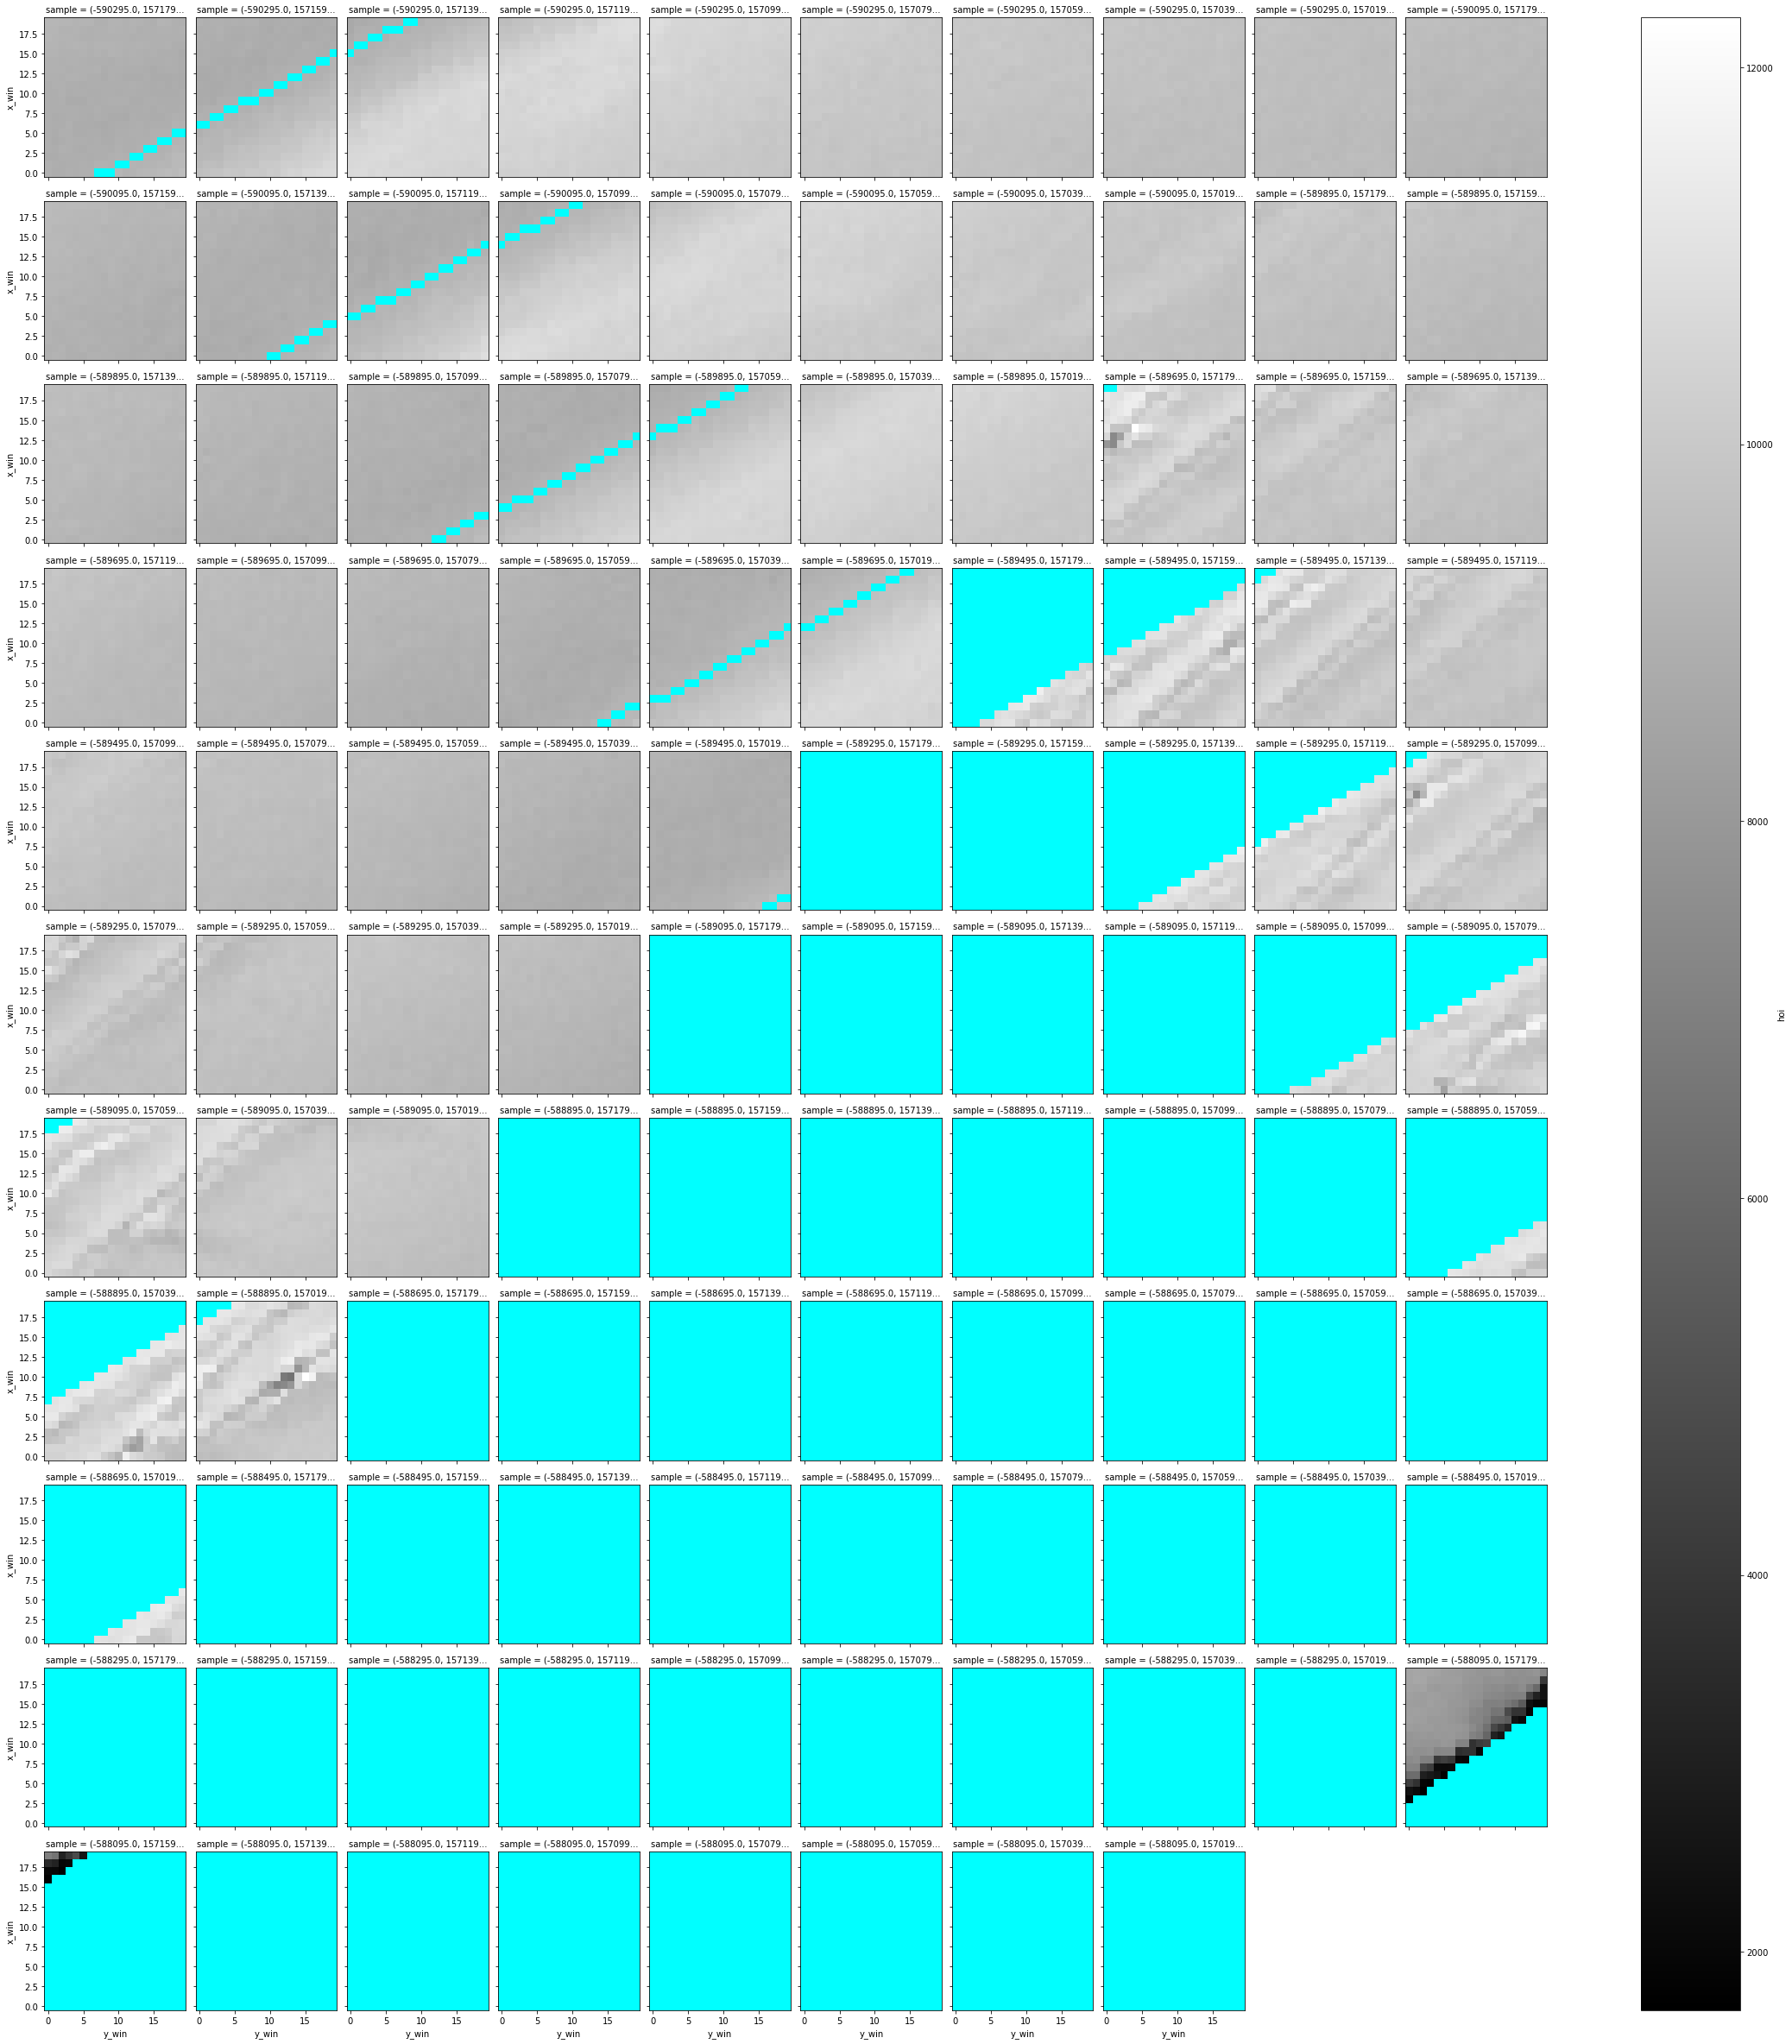

In [ ]:
## Plot facet grid

# da_area_cutouts
# da_area_cutouts.plot.FacetGrid(col='x')
# label_tile

# g_simple = da_area_cutouts.sel(band=1).isel(sample=slice(0,20)).plot(x="x_win", y="y_win", col="sample", col_wrap=10, cmap='gray')
g_simple = da_area_cutouts.sel(band=1).where(da_area_cutouts.sel(band=0)==0).plot(x="x_win", y="y_win", col="sample", col_wrap=10, 
                                                                                  cmap='gray',subplot_kws=dict(facecolor='cyan'))#, vmin=1000,vmax=10000)

# import matplotlib.cm as cm

# fig = plt.figure()
# ax = fig.add_subplot(111)
# m0=ax.contourf(lon, lat, noise, vmin=-1., vmax=2.)
# m = plt.cm.ScalarMappable(cmap=cm.coolwarm)
# g_simple.set_clim(-1, 2)
# fig.colorbar(m,ax=ax)
# cbar = fig.colorbar(g_simple)
# cbar

## extract a window from the facetgrid
# g_simple.data.loc[g_simple.name_dicts[0, 0]]

/Users/tud500158/opt/anaconda3/envs/VAEenv/lib/python3.10/site-packages/geopandas/tools/clip.py:179: UserWarning: keep_geom_type can not be called on a mixed type GeoDataFrame.
  warnings.warn(
/Users/tud500158/opt/anaconda3/envs/VAEenv/lib/python3.10/site-packages/geopandas/tools/clip.py:179: UserWarning: keep_geom_type can not be called on a mixed type GeoDataFrame.
  warnings.warn(


<AxesSubplot:title={'center':'band = 1, spatial_ref = 0'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

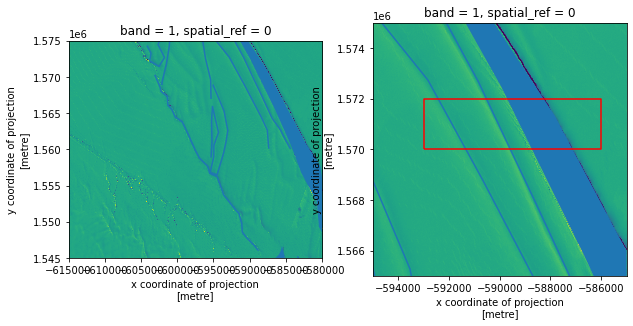

## Dev: extract clusters - most simple approach: trhreshold values
* Z1 condition: z1 > -0.025
* Z2 condition: z2 < 1.01

In [ ]:
# ## EXAMPLE 
# import rasterio as rio

# 
# img_to_match_to = da[dict(band=slice(0,1))] # da.isel(band=0)
# img = cluster_da.transpose('band','y','x')

# # -- match grid (extent, resolution and projection)
# img_repr_match = img.rio.reproject_match(img_to_match_to,resampling=rio.enums.Resampling.nearest,nodata=np.nan) # need to specify nodata, otherwise fills with (inf) number 1.79769313e+308

# # advised to update coords
# img_repr_match = img_repr_match.assign_coords({
#     "x": img_to_match_to.x,
#     "y": img_to_match_to.y,
# })
# da_conc = xr.concat([img_to_match_to, img_repr_match],dim='band',join='outer',coords='all',combine_attrs='drop_conflicts')#,fill_value=1)
# da_conc